In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances_argmin_min
import seaborn as sb
from yellowbrick.cluster import KElbowVisualizer
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import plotly.figure_factory as ff
from plotly.figure_factory import create_dendrogram
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Se cargan los datos. 
CollegeScoreCard=pd.read_csv('CollegeScorecard.csv', sep=',', encoding = 'utf-8')
# Cantidad de datos y número de variables
CollegeScoreCard.shape

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\1466162896.py:2: DtypeWarning: Columns (7,9,1427,1542,1561,1575) have mixed types. Specify dtype option on import or set low_memory=False.
  CollegeScoreCard=pd.read_csv('CollegeScorecard.csv', sep=',', encoding = 'utf-8')


(7804, 1725)

In [3]:
# data[data['INSTNM'].str.contains('niversity') & data["COSTT4_P"].notnull()]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu')]
# data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') | data['INSTNM'].str.contains('chool') | data['INSTNM'].str.contains('enter')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter') & ~data['INSTNM'].str.contains('cadem')]
# data[~data['INSTNM'].str.contains('niversity') & ~data['INSTNM'].str.contains('ollege') & ~data['INSTNM'].str.contains('nstitu') & ~data['INSTNM'].str.contains('chool') & ~data['INSTNM'].str.contains('enter') & ~data['INSTNM'].str.contains('cadem')  & ~data['INSTNM'].str.contains('CET')]
# data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') ]

In [4]:
def trans_variable_control(p):
    p_mod=''
    if p == 1:
        return "PUBLIC"
    elif p == 2:
        return "PRIVATE NONPROFIT"
    else:
        return "PRIVATE FOR-PROFIT"

In [5]:
# Depuracion y eleccion de variables
data=CollegeScoreCard[CollegeScoreCard["CURROPER"]!=0]
data=data[data["DISTANCEONLY"]!=1]
#data=data[["INSTNM","CONTROL","COSTT4_A","COSTT4_P","PCTPELL","UG25abv","PCIP11","PCIP14","PCIP16","PCIP26","PCIP27","PCIP42","PCIP52"]]
data=data[["INSTNM","CONTROL","COSTT4_A","COSTT4_P","PCTPELL","UG25abv","TUITFTE"]]
data=data[data["COSTT4_A"].notnull() | data["COSTT4_P"].notnull()]
data=data[data['INSTNM'].str.contains('niversity') | data['INSTNM'].str.contains('ollege') | data['INSTNM'].str.contains('nstitu') ]
data=data[data["COSTT4_A"].notnull()]
data=data[data['UG25abv'].notnull()]
data=data.drop(['COSTT4_P'],axis=1)
data["CONTROL"]=data["CONTROL"].apply(trans_variable_control)
data=data.drop([2124])

In [6]:
data['TUITFTE'].describe()

count     3747.000000
mean      9933.889512
std       7427.442206
min          2.000000
25%       3305.000000
50%       9194.000000
75%      14704.500000
max      61621.000000
Name: TUITFTE, dtype: float64

Para la depuración inicial de la base de datos se tomaron en cuenta las instituciones que están operando actualmente y que sean solamente presenciales. Luego seleccionamos las variables que queremos tomar en cuenta en nuestro estudio:
- Nombre de institución.
- Tipo de institución (Public, private nonprofit, private for-profit).
- Costo anual de estudio.
- Porcentaje de estudiantes con beca "PELL".
- Porcentaje de estudiantes mayores a 25 años.
- Porcentaje de diplomas entregados en diferentes areas del conocimiento (Computer Science, Engineering, Linguistics, Biological Science, Mathematics, Psychology, Business)

Luego procedemos a revisar los valores nulos de las variables seleccionadas y se eliminan los valores nulos debido a que no tienen una gran representación en la base de datos.

In [7]:
# data=data.rename(columns={'CONTROL': 'Tipo_de_Entidad','COSTT4_A': 'Costo_Anual_Estudio','PCTPELL': 'Becados_Pell','UG25abv': 'Estudiantes_Mayor_25','PCIP11': 'Computer_Science', 'PCIP14': 'Engineering','PCIP16': 'Linguistics', 'PCIP26': 'Biological_Science','PCIP27': 'Mathematics','PCIP42': 'Psychology','PCIP52': 'Business'})
data=data.rename(columns={'CONTROL': 'Tipo_de_Entidad','COSTT4_A': 'Costo_Anual_Estudio','PCTPELL': 'Becados_Pell','UG25abv': 'Estudiantes_Mayor_25','TUITFTE':'GananciaEstudiante'})

In [8]:
data['Tipo_de_Entidad'].value_counts()

PUBLIC                1584
PRIVATE NONPROFIT     1259
PRIVATE FOR-PROFIT     904
Name: Tipo_de_Entidad, dtype: int64

Se normaliza la base de datos convirtiendo las variables categóricas en "dummies" para poder usarlas en el análisis.

In [9]:
#Dymmys
data= pd.get_dummies(data, columns=['Tipo_de_Entidad'])

In [10]:
data.head()

INSTNM  Costo_Anual_Estudio  Becados_Pell  \
0             Alabama A & M University              18888.0        0.7115   
1  University of Alabama at Birmingham              19990.0        0.3505   
2                   Amridge University              12300.0        0.6839   
3  University of Alabama in Huntsville              20306.0        0.3281   
4             Alabama State University              17400.0        0.8265   

   Estudiantes_Mayor_25  GananciaEstudiante  \
0                0.1049              9063.0   
1                0.2422              9033.0   
2                0.8540             12057.0   
3                0.2640              8322.0   
4                0.1270              7813.0   

   Tipo_de_Entidad_PRIVATE FOR-PROFIT  Tipo_de_Entidad_PRIVATE NONPROFIT  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  1   
3                                   0                                  0   
4                                   0                                  0   

   Tipo_de_Entidad_PUBLIC  
0                       1  
1                       1  
2                       0  
3                       1  
4                       1

In [11]:
data.describe()

Costo_Anual_Estudio  Becados_Pell  Estudiantes_Mayor_25  \
count          3747.000000   3747.000000           3747.000000   
mean          24340.439018      0.485286              0.361186   
std           12373.111799      0.207783              0.236188   
min            4157.000000      0.000000              0.000500   
25%           13794.500000      0.328050              0.169550   
50%           22646.000000      0.453800              0.336200   
75%           30694.500000      0.639500              0.527800   
max           74473.000000      1.000000              1.000000   

       GananciaEstudiante  Tipo_de_Entidad_PRIVATE FOR-PROFIT  \
count         3747.000000                         3747.000000   
mean          9933.889512                            0.241260   
std           7427.442206                            0.427905   
min              2.000000                            0.000000   
25%           3305.000000                            0.000000   
50%           9194.000000                            0.000000   
75%          14704.500000                            0.000000   
max          61621.000000                            1.000000   

       Tipo_de_Entidad_PRIVATE NONPROFIT  Tipo_de_Entidad_PUBLIC  
count                        3747.000000             3747.000000  
mean                            0.336002                0.422738  
std                             0.472403                0.494060  
min                             0.000000                0.000000  
25%                             0.000000                0.000000  
50%                             0.000000                0.000000  
75%                             1.000000                1.000000  
max                             1.000000                1.000000

In [12]:
ies=data
university=data[data['INSTNM'].str.contains('niversity')]
college=data[data['INSTNM'].str.contains('ollege')]
institution=data[data['INSTNM'].str.contains('nstitu') ]

In [13]:
nombresIes=ies['INSTNM']
ies=ies.drop(['INSTNM'],axis=1)
nombresUniversity=university['INSTNM']
university=university.drop(['INSTNM'],axis=1)
nombresCollege=college['INSTNM']
college=college.drop(['INSTNM'],axis=1)
nombresInstitution=institution['INSTNM']
institution=institution.drop(['INSTNM'],axis=1)

Dividimos las bases de datos en 3 grupos:
- University
- College
- Institute
Luego eliminamos la columna de los nombres y procedemos a realizar los clusters.

In [14]:
# copy the data
norm_ies = ies.copy()
  
# apply normalization techniques
column = 'Costo_Anual_Estudio'
column2= 'GananciaEstudiante'
norm_ies[column] = MinMaxScaler().fit_transform(np.array(norm_ies[column]).reshape(-1,1))
norm_ies[column2] = MinMaxScaler().fit_transform(np.array(norm_ies[column2]).reshape(-1,1))

In [15]:
# copy the data
norm_university = university.copy()
norm_university[column] = MinMaxScaler().fit_transform(np.array(norm_university[column]).reshape(-1,1))
norm_university[column2] = MinMaxScaler().fit_transform(np.array(norm_university[column2]).reshape(-1,1))

In [16]:
# copy the data
norm_college = college.copy()
norm_college[column] = MinMaxScaler().fit_transform(np.array(norm_college[column]).reshape(-1,1))
norm_college[column2] = MinMaxScaler().fit_transform(np.array(norm_college[column2]).reshape(-1,1))

In [17]:
# copy the data
norm_institution = institution.copy()
norm_institution[column] = MinMaxScaler().fit_transform(np.array(norm_institution[column]).reshape(-1,1))
norm_institution[column2] = MinMaxScaler().fit_transform(np.array(norm_institution[column2]).reshape(-1,1))

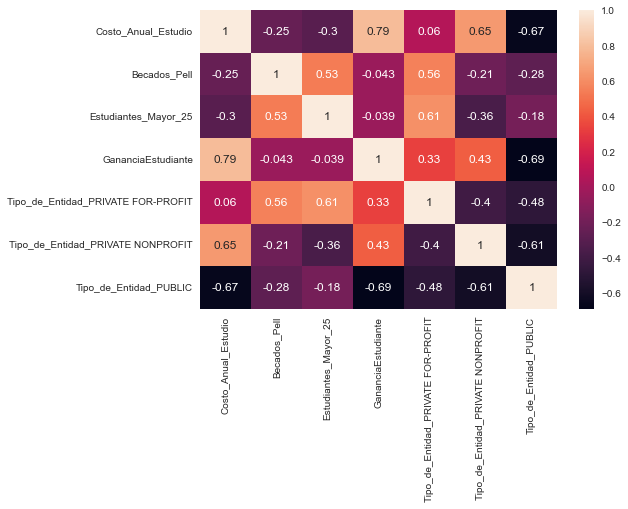

In [18]:
IescorrMatrix = norm_ies.corr()
sb.heatmap(IescorrMatrix, annot=True)
plt.show()

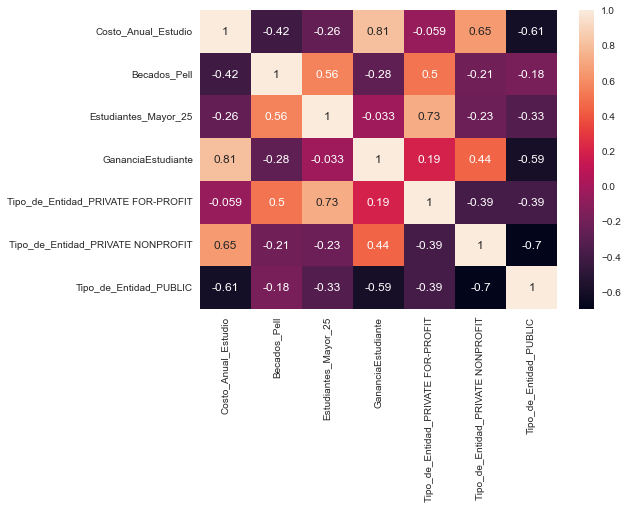

In [19]:
UnicorrMatrix = norm_university.corr()
sb.heatmap(UnicorrMatrix, annot=True)
plt.show()

Realizamos una matriz de correlación de las variables en la base de datos "University". De ésta matriz podemos destacar que las variables más correlacionadas son los estudiantes mayores de 25 años con las universidades privadas con animo de lucro con un porcentaje de correlación de 0.73.

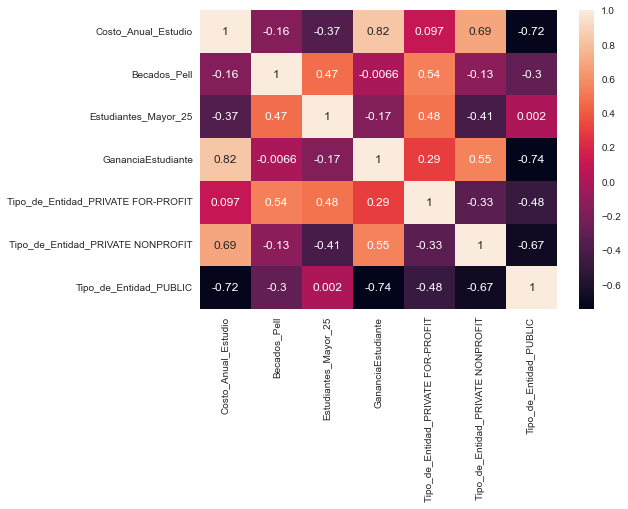

In [20]:
CollcorrMatrix = norm_college.corr()
sb.heatmap(CollcorrMatrix, annot=True)
plt.show()

Realizamos una matriz de correlación de la base de datos "college" en donde podemos destacar la correación entre "college private nonprofit" con el costo anual de estudio, la cual tiene un valor de 0.69.

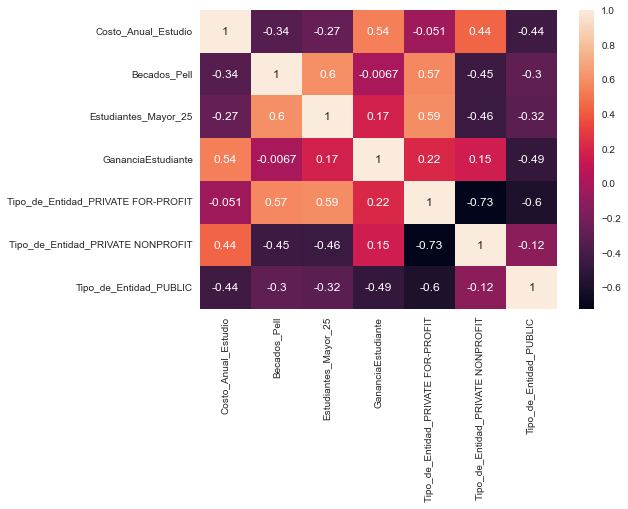

In [21]:
InstcorrMatrix = norm_institution.corr()
sb.heatmap(InstcorrMatrix, annot=True)
plt.show()

Por último realizamos la matriz de correlación de la base de datos "Institution" en la que podemos observar que la correlación mas significativa es la que hay entre los diplomas entregados en Ciencias Biológicas e Ingeniería que tiene un valor de 0.76.

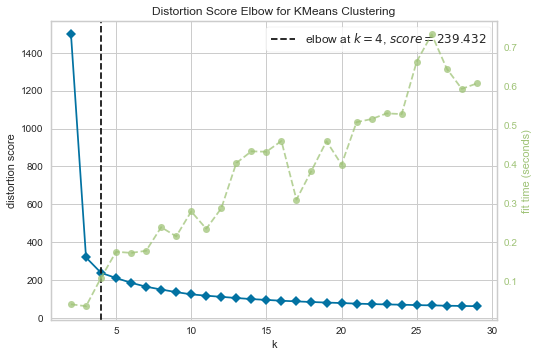

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
modelIes = KMeans()
visualizer = KElbowVisualizer(modelIes, k=(2,30), timings= True)
Iesfit=norm_ies.sample(int(len(norm_ies)*1))
visualizer.fit(Iesfit)        
visualizer.show() 

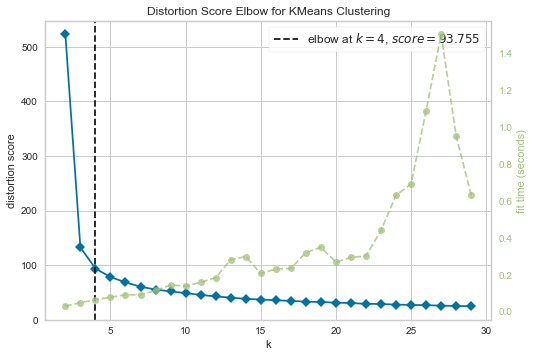

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
modelUni = KMeans()
visualizer = KElbowVisualizer(modelUni, k=(2,30), timings= True)
Unifit=norm_university.sample(int(len(norm_university)*1))
visualizer.fit(Unifit)        
visualizer.show() 

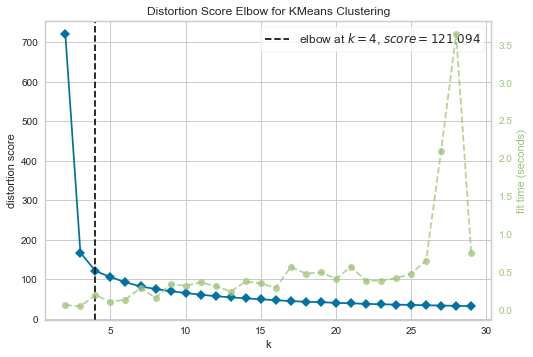

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
modelColl = KMeans()
visualizer = KElbowVisualizer(modelColl, k=(2,30), timings= True)
Collfit=norm_college.sample(int(len(norm_college)*1))
visualizer.fit(Collfit)        
visualizer.show() 

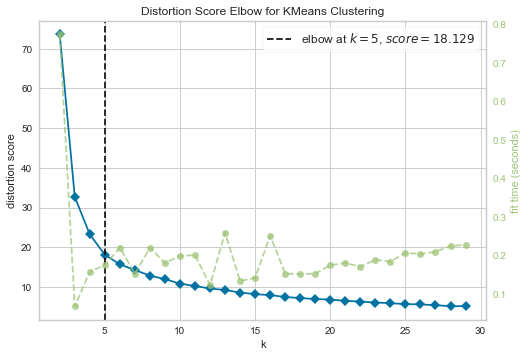

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
modelInst = KMeans()
visualizer = KElbowVisualizer(modelInst, k=(2,30), timings= True)
Instfit=norm_institution.sample(int(len(norm_institution)*1))
visualizer.fit(Instfit)        
visualizer.show() 

Realizamos la prueba de codo para conocer el número óptimo de clusters para cada base de datos en la que quedamos con 4 clusters para university y college y 6 clusters para Institution.

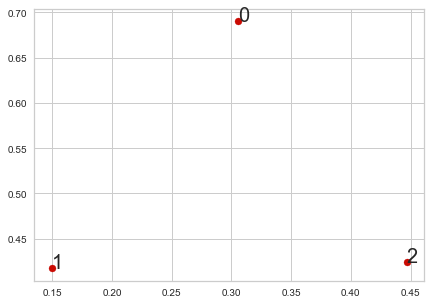

In [26]:
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(Iesfit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [27]:
ies['Nombre Universidad']=nombresIes
ies['Clasificacion']=labels_2D
ies['Clasificacion'].value_counts()

grupo0=ies[ies['Clasificacion']==0]
grupo1=ies[ies['Clasificacion']==1]
grupo2=ies[ies['Clasificacion']==2]
# grupo3=ies[ies['Clasificacion']==3]

df=pd.DataFrame()
df['grupo0']=grupo0.mean()
df['grupo1']=grupo1.mean()
df['grupo2']=grupo2.mean()
# df['grupo3']=grupo3.median()
df

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\3656528903.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['grupo0']=grupo0.mean()
C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\3656528903.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['grupo1']=grupo1.mean()
C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\3656528903.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['grupo2']=grupo2.mean()


grupo0        grupo1        grupo2
Costo_Anual_Estudio                 23898.421460  24754.244318  24137.195393
Becados_Pell                            0.487597      0.484764      0.484285
Estudiantes_Mayor_25                    0.376804      0.352945      0.360340
GananciaEstudiante                   9791.269912  10289.500000   9588.886418
Tipo_de_Entidad_PRIVATE FOR-PROFIT      0.256637      0.246843      0.223193
Tipo_de_Entidad_PRIVATE NONPROFIT       0.328540      0.340278      0.335981
Tipo_de_Entidad_PUBLIC                  0.414823      0.412879      0.440826
Clasificacion                           0.000000      1.000000      2.000000

In [28]:
# dict for the dataframes and their names
dfs = {"grupo0" : grupo0, "grupo1": grupo1, "grupo2" : grupo2}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Box(y = dfs[i]["Costo_Anual_Estudio"], 
                                   name = i))
fig.show()

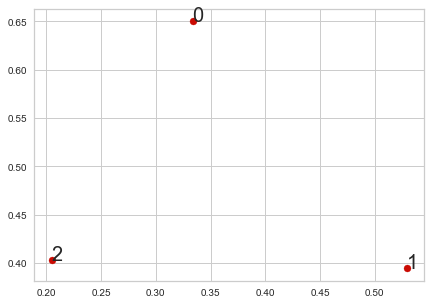

In [29]:
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(Unifit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [30]:
university['Nombre Universidad']=nombresUniversity
university['Clasificacion']=labels_2D
university['Clasificacion'].value_counts()

grupo0=university[university['Clasificacion']==0]
grupo1=university[university['Clasificacion']==1]
grupo2=university[university['Clasificacion']==2]
# grupo3=university[university['Clasificacion']==3]

df=pd.DataFrame()
df['grupo0']=grupo0.median()
df['grupo1']=grupo1.median()
df['grupo2']=grupo2.median()
# df['grupo3']=grupo3.median()
df

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\1903386970.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\1903386970.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\1903386970.py:13: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



grupo0       grupo1      grupo2
Costo_Anual_Estudio                 24420.0000  23882.50000  24166.5000
Becados_Pell                            0.3921      0.42055      0.4186
Estudiantes_Mayor_25                    0.2370      0.23805      0.2213
GananciaEstudiante                  11139.0000  10434.00000  10866.5000
Tipo_de_Entidad_PRIVATE FOR-PROFIT      0.0000      0.00000      0.0000
Tipo_de_Entidad_PRIVATE NONPROFIT       0.0000      0.00000      0.0000
Tipo_de_Entidad_PUBLIC                  0.0000      0.00000      0.0000
Clasificacion                           0.0000      1.00000      2.0000

In [31]:
# dict for the dataframes and their names
dfs = {"grupo0" : grupo0, "grupo1": grupo1, "grupo2" : grupo2}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Box(y = dfs[i]["Costo_Anual_Estudio"], 
                                   name = i))
fig.show()

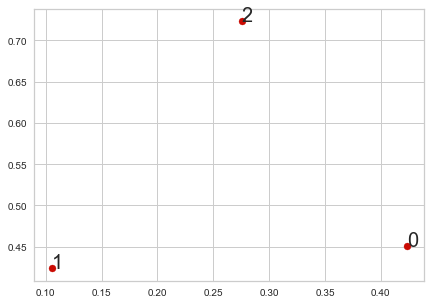

In [32]:
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(Collfit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [33]:
college['Nombre Collage']=nombresCollege
college['Clasificacion']=labels_2D
college['Clasificacion'].value_counts()

grupo0=college[college['Clasificacion']==0]
grupo1=college[college['Clasificacion']==1]
grupo2=college[college['Clasificacion']==2]
# grupo3=college[college['Clasificacion']==3]

df=pd.DataFrame()
df['grupo0']=grupo0.median()
df['grupo1']=grupo1.median()
df['grupo2']=grupo2.median()
# df['grupo3']=grupo3.median()
df

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\138277775.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\138277775.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\138277775.py:13: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



grupo0      grupo1      grupo2
Costo_Anual_Estudio                 18415.50000  16752.0000  16185.0000
Becados_Pell                            0.45845      0.4562      0.4463
Estudiantes_Mayor_25                    0.36925      0.3708      0.3541
GananciaEstudiante                   6314.00000   4755.0000   4367.0000
Tipo_de_Entidad_PRIVATE FOR-PROFIT      0.00000      0.0000      0.0000
Tipo_de_Entidad_PRIVATE NONPROFIT       0.00000      0.0000      0.0000
Tipo_de_Entidad_PUBLIC                  0.00000      0.0000      1.0000
Clasificacion                           0.00000      1.0000      2.0000

In [34]:
# dict for the dataframes and their names
dfs = {"grupo0" : grupo0, "grupo1": grupo1, "grupo2" : grupo2}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Box(y = dfs[i]["Costo_Anual_Estudio"], 
                                   name = i))
fig.show()

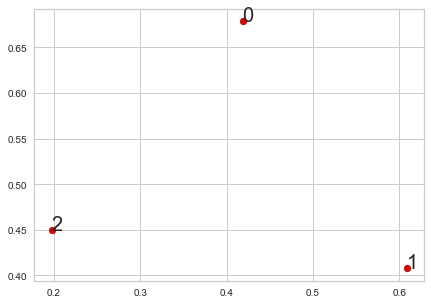

In [35]:
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(Instfit)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_
fig, ax = plt.subplots(figsize=(7, 5))

plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', marker='o')

for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

In [36]:
institution['Nombre Collage']=nombresInstitution
institution['Clasificacion']=labels_2D
institution['Clasificacion'].value_counts()

grupo0=institution[institution['Clasificacion']==0]
grupo1=institution[institution['Clasificacion']==1]
grupo2=institution[institution['Clasificacion']==2]
# grupo3=institution[institution['Clasificacion']==3]

df=pd.DataFrame()
df['grupo0']=grupo0.median()
df['grupo1']=grupo1.median()
df['grupo2']=grupo2.median()
# df['grupo3']=grupo3.median()
df

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\2025697446.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\2025697446.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Edwar\AppData\Local\Temp\ipykernel_8980\2025697446.py:13: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



grupo0       grupo1      grupo2
Costo_Anual_Estudio                 27074.0000  26994.00000  27328.0000
Becados_Pell                            0.6620      0.69505      0.6597
Estudiantes_Mayor_25                    0.5841      0.64835      0.5364
GananciaEstudiante                  16607.0000  16471.00000  16549.0000
Tipo_de_Entidad_PRIVATE FOR-PROFIT      1.0000      1.00000      1.0000
Tipo_de_Entidad_PRIVATE NONPROFIT       0.0000      0.00000      0.0000
Tipo_de_Entidad_PUBLIC                  0.0000      0.00000      0.0000
Clasificacion                           0.0000      1.00000      2.0000

In [37]:
# dict for the dataframes and their names
dfs = {"grupo0" : grupo0, "grupo1": grupo1, "grupo2" : grupo2}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Box(y = dfs[i]["Costo_Anual_Estudio"], 
                                   name = i))
fig.show()

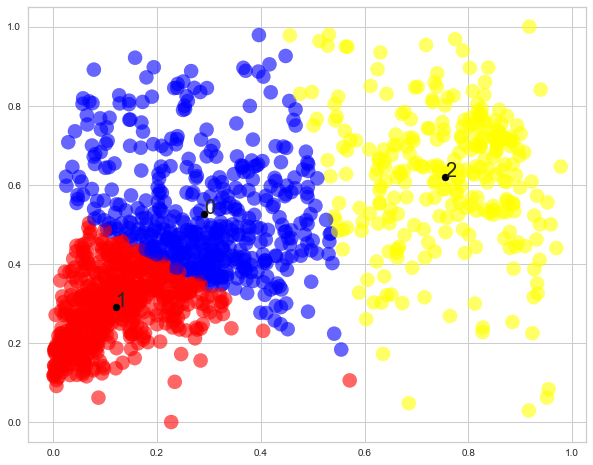

In [38]:
df_2D = norm_university[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red','yellow']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

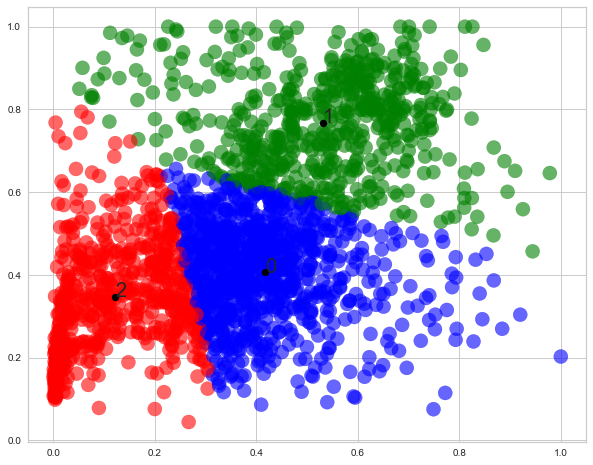

In [39]:
df_2D = norm_college[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)

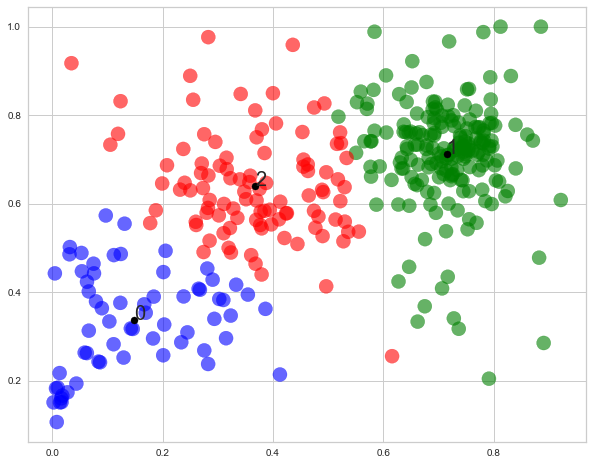

In [40]:
df_2D = norm_institution[['Estudiantes_Mayor_25', 'Becados_Pell']]
df_2D = np.array(df_2D)
kmeans_model_2D = KMeans(n_clusters=3, max_iter=1000).fit(df_2D)
labels_2D = kmeans_model_2D.labels_
centroids_2D = kmeans_model_2D.cluster_centers_

colors_k_means = ['blue','green','red']
 
fig = plt.figure(figsize=(10, 8))
plt.scatter(df_2D[:, 0], df_2D[:, 1], c=labels_2D, s=200,
            cmap=matplotlib.colors.ListedColormap(colors_k_means), alpha=0.6)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], c='black', s=200, marker='.')

for i in range(len(centroids_2D)):
    plt.annotate( i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=20)